<a href="https://colab.research.google.com/github/NOKOGIDO/Time-to-Event/blob/main/Modelos/DeepSurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DeepSurv**

En este cuaderno se empleará el método Cox-PH, también conocido como **DeepSurv**.  

Cox-PH es un método de tiempo continuo, es decir, no es necesario discretizar la escala de tiempos.

In [ ]:
!git clone https://github.com/havakv/pycox.git

Cloning into 'pycox'...
remote: Enumerating objects: 1752, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 1752 (delta 81), reused 116 (delta 70), pack-reused 1603
Receiving objects: 100% (1752/1752), 2.51 MiB | 6.57 MiB/s, done.
Resolving deltas: 100% (1138/1138), done.


In [ ]:
! pip install sklearn-pandas

In [ ]:
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.9 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2435 sha256=917a22fb66a8c88cabcc3d33f1369324d25f3137e13073a1024b8b8fceab3c84
  Stored in directory: /root/.cache/pip/wheels/a6/ff/5d/4f10de26fe5ddef243c

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
#from pycox.datasets import support
#from pycox.datasets import gbsg
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [ ]:
np.random.seed(2587)
_ = torch.manual_seed(258)

# **Dataset**

Cargamos el dataset METABRIC (en este apartado podemos cambiar para seleccionar el dataset Rot. & GBSG o el dataset SUPPORT) y hacemos las particiones de entrenamiento, test y validación.

In [ ]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Dataset 'metabric' not locally available. Downloading...
Done


In [ ]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
7,5.916774,5.289600,12.981733,6.009507,0.0,1.0,0.0,1.0,64.610001,143.000000,1
8,5.865741,6.738176,10.850687,5.596416,0.0,0.0,0.0,1.0,68.209999,150.600006,1
11,6.333529,5.170259,8.742507,6.500216,0.0,1.0,1.0,0.0,55.020000,141.166672,0


# **Transformación de Características**

Tenemos una serie de variables, además de las duracionese indicadores de eventos.

Estandarizamos las variables numéricas y mantenemos las variables binarias. Las variables deben ser de tipo 'float32', ya que es necesario para el correcto funcionamiento de pytorch. Dependiendo del dataset seleccionado, debemos ajustar el número y tipo de variables, para su estandarización.

In [ ]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

No es necesario hacer transformación para las etiquetas.

In [ ]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

# **Neural Net**

Creamos un MLP simple (Perceptrón Multicapa) con dos capas ocultas, activación ReLU, Batch Norm y Dropout. Empleamos la red **torchtuples.practical.MLPVanilla** para hacer esto.
Establecemos **out_features** en 1 y no tenemos **output_bias.**

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

# **Entrenamos el Modelo**

Para entrenar el modelo, es necesario definir un optimizador. En este caso se emplea **tt.optim** para la selección, ya que tiene alguna funcionalidad adicional. Se utiliza el optimizador Adam, pero en lugar de fijar una tasa de aprendizaje, usaremos el esquema propuesto por  [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf), para encontar una tase de aprendizaje adecuada con **model.lr_finder**.

In [ ]:
model = CoxPH(net, tt.optim.Adam)

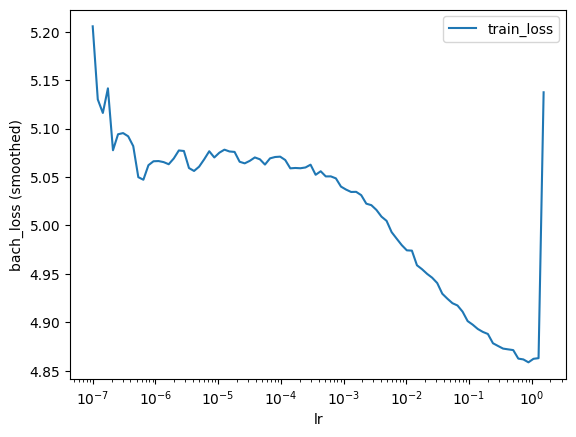

In [ ]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

0.08902150854450441

A menudo, esta tasa de aprendizaje es elevada, por lo que configuramos la tasa de aprendizaje manualmente en 0.01

In [ ]:
model.optimizer.set_lr(0.01)

Se incluye **EarlyStopping**, para detener el entrenamiento cuando la función de pérdida de validación deja de mejorar. Después del entrenamiento, esta devolución de llamada también cargará el modelo con mejor desempeño en términos de pérdida de validación.

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.8709,	val_loss: 3.9634
1:	[0s / 0s],		train_loss: 4.7352,	val_loss: 3.9313
2:	[0s / 0s],		train_loss: 4.6900,	val_loss: 3.9187
3:	[0s / 0s],		train_loss: 4.6722,	val_loss: 3.9135
4:	[0s / 0s],		train_loss: 4.6567,	val_loss: 3.9104
5:	[0s / 0s],		train_loss: 4.6455,	val_loss: 3.9100
6:	[0s / 0s],		train_loss: 4.6353,	val_loss: 3.9134
7:	[0s / 0s],		train_loss: 4.6404,	val_loss: 3.9199
8:	[0s / 0s],		train_loss: 4.6247,	val_loss: 3.9159
9:	[0s / 0s],		train_loss: 4.6187,	val_loss: 3.9212
10:	[0s / 0s],		train_loss: 4.6026,	val_loss: 3.9200
11:	[0s / 0s],		train_loss: 4.6290,	val_loss: 3.9224
12:	[0s / 0s],		train_loss: 4.6167,	val_loss: 3.9298
13:	[0s / 0s],		train_loss: 4.6057,	val_loss: 3.9299
14:	[0s / 0s],		train_loss: 4.6072,	val_loss: 3.9185
15:	[0s / 0s],		train_loss: 4.5849,	val_loss: 3.9387
CPU times: user 339 ms, sys: 11.2 ms, total: 350 ms
Wall time: 358 ms


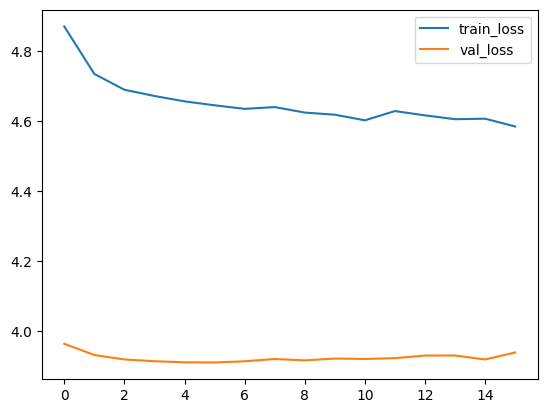

In [ ]:
_ = log.plot()

In [ ]:
model.partial_log_likelihood(*val).mean()

-4.872988

# **Predicción**

Para la validación, es necesario obtener estimaciones de supervivenia para el conjunto de prueba. Esto se puede hacer con **model.predict_surv**, que nos devuelve una serie de estimaciones de supervivencia o con **model.predict_surv_df**, que devuelve las estimaciones de supervivencia como un marco de datos.

Sin embargo, como Cox-PH es semiparamétrico, primero debemos obtener las estimaciones de peligro de referencia no paramétricas con **compute_baseline_hazards**. Tenga en cuenta que para grandes conjuntos de datos, el argumento **sample**, se puede utilizar para estimar el peligro de referencia en un subconjunto.

In [ ]:
_ = model.compute_baseline_hazards()

In [ ]:
surv = model.predict_surv_df(x_test)

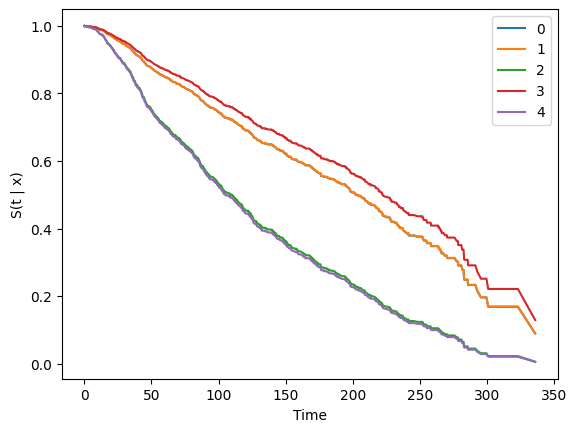

In [ ]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# **Evaluación**

Podemos usar la clase **EvalSurv** para evaluar la concordancia, la puntuación de Brier y la Verosimilitud Binomial. La configuración **censor_surv='km'** significa que estimamos la distribución de censura por **Kaplan-Meier** en el conjunto de prueba.

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [ ]:
ev.concordance_td()

0.6506225453329991

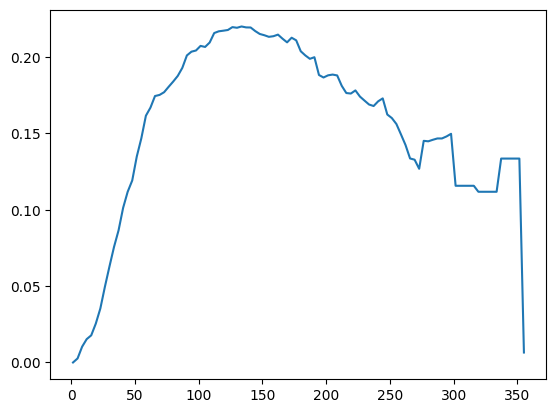

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [ ]:
ev.integrated_brier_score(time_grid)

0.15569684661059358

In [ ]:
ev.integrated_nbll(time_grid)

0.47090486623506117